# Modular coding - simple modularity

## Toy example with pure PyTorch

Let's consider the following simple toy model (multilayer perceptron) training code:

In [1]:
# Import needed modules
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

### Data loading

In PyTorch datasets are loaded via DataLoaders. Here we create training and testing datasets.

In [2]:
# Set up data sets and data loaders

data_dir = "./data"

batch_size = 32

train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model specification

In PyTorch modules are subclasses of `nn.Module` and they implement their own `forward`-function that describes the forward pass of the model.

Here is the structure for the simple multilayer perceptron model were using:

```mermaid
flowchart TD
    I["Input (output: batch x 28 x 28)"] --> F["Flatten (output: batch x 784)"];
    F --> H["Hidden linear layer (output: batch x 20)"];
    H --> A["ReLU activation (output: batch x 20)"];
    A --> O["Output linear layer (output: batch x num categories)"];
```

In [3]:
# Specify model

device = "cuda" if torch.cuda.is_available() else "cpu"


class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 20), nn.ReLU(), nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)


model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


### Loss and optimizer specification

For the training we'll need to specify a loss function (for classification problem we'll use a [torch.nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

For optimizer we'll use [torch.optim.AdamW](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html), which is nowadays one of the most popular optimizers.

In [4]:
# Specify loss and optimizer

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

### Training

For the training we need to iterate over multiple epochs and during each epoch we need to:

1. Go through all of the training data in batches
2. Feed each batch to our model
3. Calculate loss based on model output
4. Calculate gradients of weights from the loss with backwards propagation
5. Update parameters of our model based on optimizer strategy
6. Zero gradients and move to next batch
7. Measure our model's training progression

In code it will look something like this:

In [5]:
# Train the model

model.train()

num_batches = len(train_loader)
num_items = len(train_loader.dataset)
losses = []
accuracies = []
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for data, target in tqdm(train_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, target)
        total_loss += loss.item()

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    accuracy = total_correct / num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    losses.append(train_loss)
    accuracies.append(accuracy)

100%|██████████| 1875/1875 [00:03<00:00, 506.51it/s]


Average loss: 0.424244, accuracy: 88.40%


100%|██████████| 1875/1875 [00:03<00:00, 533.41it/s]


Average loss: 0.248386, accuracy: 92.98%


100%|██████████| 1875/1875 [00:03<00:00, 516.95it/s]


Average loss: 0.211200, accuracy: 93.94%


100%|██████████| 1875/1875 [00:03<00:00, 551.66it/s]


Average loss: 0.189071, accuracy: 94.60%


100%|██████████| 1875/1875 [00:03<00:00, 530.47it/s]

Average loss: 0.172662, accuracy: 95.08%


### Visualizing training

Often we'll want to visualize some metrics that show how the model training is progressing:

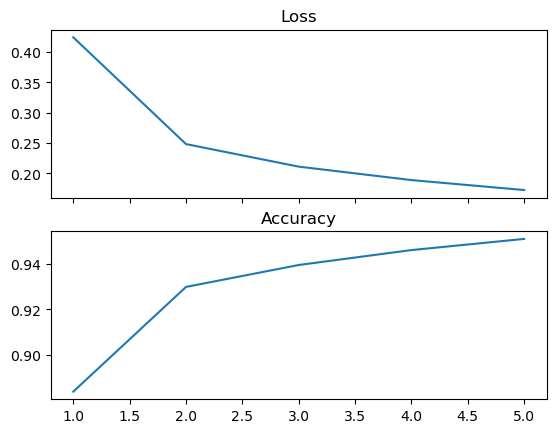

In [6]:
batch_index = np.arange(1, len(losses) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(batch_index, np.asarray(losses))
ax1.set_title("Loss")
ax2.plot(batch_index, np.asarray(accuracies))
ax2.set_title("Accuracy")

fig.show()

### Testing the model

After the training has finished we'll want to verify our model's performance by utilizing a test set that the model has not seen during the training process.

In [7]:
# Test the model
model.eval()

num_test_batches = len(test_loader)
num_test_items = len(test_loader.dataset)

test_total_correct = 0
for data, target in tqdm(test_loader, total=num_test_batches):
    # Copy data and targets to GPU
    data = data.to(device)
    target = target.to(device)

    # Do a forward pass
    outputs = model(data)

    # Count number of correct digits
    _, predicted = torch.max(outputs, 1)
    test_total_correct += (predicted == target).sum().item()

test_accuracy = test_total_correct / num_test_items
print(f"Testing accuracy: {test_accuracy:.2%}")

100%|██████████| 313/313 [00:00<00:00, 817.45it/s]

Testing accuracy: 95.06%


## Quick modular improvements

Because the model and dataset are very simple, the code is relatively clean and it can be organized in a linear fashion. But even for such an simple setup it can quickly become hard to read. See `examples/example1` for a script version of the previously shown code. There is no delineation between different phases and thus to understand what the code is doing, you'll need to read all of it.

However it can be made clearer and more modular by writing different parts as functions.

In [8]:
# Reset the notebook
%reset -f

In [9]:
# Redo imports
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

### Dataloaders

Creating the data loaders can be split into its own function:

In [10]:
def create_dataloaders(train_dataset, test_dataset, batch_size=32):
    # Set up data loaders based on datasets

    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

### Model

Model creation can be done in a separate function that accepts a model structure and optimizer class as its inputs:

In [11]:
def create_model(model_structure, optimizer_class, device="cpu"):
    # Define function for getting model and optimizer
    model = model_structure().to(device)
    optimizer = optimizer_class(model.parameters())
    return model, optimizer

### Training

Training loop can be separated into its own function:

In [12]:
# Define a train-function
def train(
    model, dataloader, criterion, optimizer, batch_size=32, epochs=5, device="cpu"
):

    model.train()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)
    losses = []
    accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        for data, target in tqdm(dataloader, total=num_batches):
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            outputs = model(data)

            # Calculate the loss
            loss = criterion(outputs, target)
            total_loss += loss.item()

            # Count number of correct digits
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == target).sum().item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = total_loss / num_batches
        accuracy = total_correct / num_items
        print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
        losses.append(train_loss)
        accuracies.append(accuracy)

    return losses, accuracies

### Testing

Same can be done for testing:

In [13]:
# Define a test-function

def test(model, dataloader, criterion, device="cpu"):
    # Test the model
    model.eval()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)

    total_correct = 0
    for data, target in tqdm(test_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

    accuracy = total_correct / num_items
    print(f"Testing accuracy: {accuracy:.2%}")
    return accuracy

### Plotting results

Lets create a function for plotting results:

In [14]:
def plot_training(losses, accuracies):

    batch_index = np.arange(1, len(losses) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ax1.plot(batch_index, np.asarray(losses))
    ax1.set_title("Loss")
    ax2.plot(batch_index, np.asarray(accuracies))
    ax2.set_title("Accuracy")

    return fig, (ax1, ax2)

### Using the modular version of the code

In [15]:
# Set all variables

data_dir = "./data"
train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())
batch_size = 32


class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 20), nn.ReLU(), nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)


model_structure = SimpleMLP
optimizer_class = torch.optim.AdamW
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
train_loader, test_loader = create_dataloaders(
    train_dataset, test_dataset, batch_size=32
)
model, optimizer = create_model(model_structure, optimizer_class, device=device)

In [17]:
# Train the model
losses, accuracies = train(
    model,
    train_loader,
    criterion,
    optimizer,
    batch_size=batch_size,
    epochs=epochs,
    device=device,
)

100%|██████████| 1875/1875 [00:03<00:00, 526.95it/s]


Average loss: 0.422513, accuracy: 88.50%


100%|██████████| 1875/1875 [00:03<00:00, 556.39it/s]


Average loss: 0.226511, accuracy: 93.56%


100%|██████████| 1875/1875 [00:03<00:00, 511.47it/s]


Average loss: 0.190579, accuracy: 94.54%


100%|██████████| 1875/1875 [00:03<00:00, 538.17it/s]


Average loss: 0.169077, accuracy: 95.17%


100%|██████████| 1875/1875 [00:03<00:00, 525.76it/s]

Average loss: 0.154787, accuracy: 95.56%


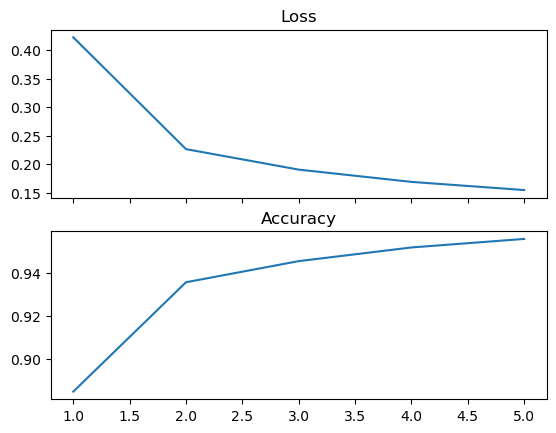

In [18]:
# Plot training
fig, axes = plot_training(losses, accuracies)

fig.show()

In [19]:
# Test the model

test(model, test_loader, criterion, device=device)

100%|██████████| 313/313 [00:00<00:00, 825.85it/s]

Testing accuracy: 95.56%


0.9556

### Conclusions

The new script is available in `examples/example2`. Looking at the script it is much faster to see the different parts of the code. The contents of the code is the same, but the added modularity keeps different parts of the code from being merged together. This in turn makes debugging the program much simpler.